# A de Agro - Pipeline de Processamento e Base de Dados - Sprint 1

## Identificação de Talhões de Terras Agrículas com Satélites do Programa Sentinel-2

Este notebook descreve o processo de download manual, rotulação e análise preliminar de imagens de satélite do Sentinel-2 para identificação de talhões de terras agrícolas. O objetivo é utilizar essas informações para treinamento de modelos de visão computacional que podem identificar terras agriculturáveis a partir de imagens de satélite.

In [ ]:
!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 41.8 MB/s eta 0:00:00


In [ ]:
# Importando as bibliotecas necessárias
import os
import cv2
import rasterio
import unittest
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.image as img
import matplotlib.pyplot as plt
import shutil

from rasterio.plot import show
from PIL import Image, ImageEnhance
from rasterio.features import rasterize
from skimage.util import random_noise


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Descrição da Fonte de Dados

**Sentinel-2** é uma missão de observação da Terra desenvolvida pela Agência Espacial Europeia (ESA), parte do programa Copernicus. Consiste em dois satélites, o Sentinel-2A e o Sentinel-2B, que fornecem imagens multiespectrais de alta resolução. Estes satélites são equipados com o sensor MSI (MultiSpectral Instrument), que captura imagens em 13 bandas espectrais diferentes com resoluções que variam de 10m a 60m por pixel.

A escolha dos dados do Sentinel-2 para este projeto se justifica pela sua alta resolução espacial, alta frequência de revisita (até 5 dias), e acesso livre e aberto, o que é ideal para monitoramento contínuo e detalhado do uso da terra.


## Etapa Inicial - Download e Rotulação Manual

Optamos pelo download e rotulação manual das imagens por várias razões:
1. **Precisão Específica**: A precisão exigida na identificação de pequenos talhões de terras agrícolas pode não ser alcançada por métodos automáticos inicialmente devido à complexidade das paisagens e à sobreposição de culturas.
2. **Controle Total**: O processo manual nos permite controlar totalmente a seleção das áreas de interesse e a qualidade das anotações, garantindo que os dados estejam perfeitamente alinhados com os objetivos específicos do projeto.
3. **Treinamento de Modelos**: A rotulação manual proporciona exemplos de alta qualidade que são cruciais para o treinamento eficaz de modelos de aprendizado profundo.


### Download Manual de Imagens do Sentinel-2

Para realizar o download das imagens do Sentinel-2, utilizaremos o navegador EO Browser. Siga os passos abaixo para selecionar e baixar as imagens apropriadas para o projeto:

1. Acesse o EO Browser através do link: [EO Browser](https://apps.sentinel-hub.com/eo-browser/)
2. Crie uma conta gratuita ou faça login se já possuir uma.
3. No campo de busca, digite a localização de interesse ou use as ferramentas de mapa para navegar até a área desejada.
4. Selecione o intervalo de datas que deseja explorar. Como se trata de um projeto agrícola, considere as épocas de plantio e colheita (os meses variam conforme o tipo de plantação).
5. Escolha 'Sentinel-2' no menu de satélites disponíveis.
6. Aplique filtros necessários, como cobertura de nuvens, para melhorar a qualidade das imagens obtidas.
6. Assegure-se que a imagem que você está escolhendo pertence ao Dataset *Sentinel-2 L2A*. Esse dataset já têm as correções atmosféricas necessárias, que podem melhorar a performance do algoritmo segundo os artigos acadêmicos usados como referência adiante.
7. Selecione a imagem ou imagens que correspondem aos critérios estabelecidos e proceda com o download.

**Nota**: Garanta que as imagens baixadas tenham a cobertura necessária das áreas de interesse e estejam livres de obstruções significativas, como nuvens ou sombras.


### Rotulação Manual Usando QGIS

Após o download das imagens, o próximo passo é a rotulação manual dos talhões de terra usando QGIS. Aqui estão as instruções para rotular as imagens corretamente:

1. Instale o QGIS no seu computador se ainda não estiver instalado. O download pode ser feito através do site oficial: [Download QGIS](https://www.qgis.org/pt_BR/site/forusers/download.html)
2. Abra o QGIS e crie um novo projeto.
3. Importe as imagens do Sentinel-2 baixadas anteriormente usando a opção 'Layer' -> 'Add Layer' -> 'Add Raster Layer'.
4. Utilize as ferramentas de desenho do QGIS para delinear os talhões. Isso pode ser feito adicionando um novo 'Shapefile Layer' e utilizando a ferramenta 'Add Polygon' para desenhar sobre as áreas de interesse.
5. Salve os shapefiles criados com a rotulação. Certifique-se de manter uma organização clara dos arquivos para facilitar o acesso e a referência futura.

**Dicas Importantes**:
- Mantenha a consistência nas rotulações para facilitar o treinamento do modelo.
- Use um sistema de referência de coordenadas adequado para a região de estudo para garantir precisão geográfica.
- Anote características relevantes de cada talhão, como tipo de cultura, estágio de crescimento ou outras observações pertinentes.


### Justificativa dos Novos Dados
Uma das imagens escolhida foi da região de Carlópolis-PR. Segundo o IBGE, em 2022 essa região foi a maior produtora de café do estado do Paraná, cultura que pode ser plantada em altitudes mais elevadas. Dessa forma, consegue-se uma região tanto com talhões irregulares quanto regulares que podem beneficiar o modelo em sua performance na região Sul.

A criação das máscaras foi feita analisando a região ao longo do tempo para identificar pontos que variavam e possivelmente são talhões.

### Referências da Fonte de Dados

Abaixo, estão algumas referências úteis que fornecem informações adicionais sobre o Sentinel-2 e seu uso em aplicações de observação da Terra:

1. **Agência Espacial Europeia (ESA) - Sentinel-2**:
   - Página oficial do Sentinel-2: [ESA Sentinel-2](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2)
   - Informações técnicas sobre o sensor MSI e especificações das bandas espectrais: [MSI Sensor](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi)

2. **Copernicus Open Access Hub**:
   - Acesso aos dados do Sentinel-2: [Copernicus Open Access Hub](https://scihub.copernicus.eu/)

3. **Sentinel Hub EO Browser**:
   - Ferramenta para visualização e download de imagens de satélite: [EO Browser](https://apps.sentinel-hub.com/eo-browser/)

4. **Documentação e Tutoriais QGIS**:
   - Para aprender mais sobre como usar o QGIS para rotulação manual e análise geoespacial: [QGIS Documentation](https://docs.qgis.org/3.34/en/docs/index.html)

5. **Artigos e Estudos Relevantes**:
   - Campos-Taberner, M. et al., "Understanding deep learning in land use classification based on Sentinel-2 time series," *Scientific Reports*, 2020. Disponível em: [Scientific Reports](https://www.nature.com/articles/s41598-020-74215-5)
   - Debella-Gilo,M.; Gjertsen, A.K. Mapping Seasonal Agricultural Land Use Types Using Deep Learning on Sentinel-2 Image Time Series. [Remote Sens. 2021, 13, 289.](https://doi.org/10.3390/rs13020289)

6. **IBGE**
   - Informação sobre agropecuária no Brasil: [IBGE](https://www.ibge.gov.br/explica/producao-agropecuaria/)

## Conversão de Rótulos do QGIS para Formato Adequado para Aprendizado de Máquina

Após rotular manualmente os talhões no QGIS, é necessário converter esses rótulos em um formato que possa ser utilizado por modelos de aprendizado de máquina. Isso geralmente envolve a criação de máscaras ou anotações que correspondam diretamente às imagens de satélite.


In [ ]:
def change_mask_color(img):
  """
  Passa a máscara de vermelho e preto para preto e branco (sendo os talhões brancos)
  Args:
    img: imagem da máscara original
  Returns:
    img: imagem em preto e branco
  """
  for i in range(len(img)):
    for j in range(len(img)):
      if img[i][j][0] == 255:
        img[i][j][0] = 0
        img[i][j][1] = 0
        img[i][j][2] = 0
      else:
        img[i][j][0] = 255
        img[i][j][1] = 255
        img[i][j][2] = 255
  return img

In [ ]:
def generate_mask_tiff(gpkg_path, tiff_path, dir):

  root_dir = "/content/drive/MyDrive/Satelite Data/origin_imgs/"

  # Carregar shapefile com rótulos
  labels = gpd.read_file(gpkg_path)
  gpkg_name = gpkg_path.split("/")[len(gpkg_path.split("/")) - 1].split(".")[0]
  tiff_name = tiff_path.split("/")[len(tiff_path.split("/")) - 1].split(".")[0]

  # Definir transformação e metadados com base na imagem do Sentinel-2
  with rasterio.open(root_dir+tiff_path) as src:
      transform = src.transform
      meta = src.meta

  # Converter polígonos em uma máscara
  mask = rasterize(
      [(geom, 1) for geom in labels.geometry],
      out_shape=(src.height, src.width),
      transform=transform,
      fill=255,
      all_touched=True,
      dtype='uint8'
  )

  # Salvar a máscara como um arquivo raster
  with rasterio.open(dir + f'/{gpkg_name}.tif', 'w', **meta) as dest:
      dest.write(mask, 1)

  with rasterio.open(dir + f'/{gpkg_name}.tif') as mask_src:
      img_mask = img.imread(dir + f'/{gpkg_name}.tif')
      img_copy = np.copy(img_mask)
      changed_img = change_mask_color(img_copy)

  single_channel = changed_img[:,:,0]
  # transforma de RGB para um único valor
  #grayscale_img = 0.2989 * changed_img[:, :, 0] + 0.5870 * changed_img[:, :, 1] + 0.1140 * changed_img[:, :, 2]

  with rasterio.open(dir + f'/{gpkg_name}.tif') as src:
      meta = src.meta

  meta.update(count=1, dtype=rasterio.float32)

  # Salva a máscara em preto e branco
  with rasterio.open(dir + f'/{gpkg_name}.tif', 'w', **meta) as dest:
      dest.write(single_channel.astype(rasterio.float32), 1)

  return dir + f'/{gpkg_name}.tif'


## Pré-Processamento das Imagens do Sentinel-2

Para o projeto de identificação de talhões, as imagens do Sentinel-2 serão pré-processadas para garantir a qualidade e a precisão das análises subsequentes. Como mencionado anteriormente, optamos por utilizar imagens do tipo L2A, que já incluem correções atmosféricas, simplificando significativamente o processo de pré-processamento. As etapas a seguir são ajustadas para preparar as imagens para o processo de identificação dos talhões, sem assumir conhecimento prévio sobre suas localizações:

1. **Alinhamento Geométrico**: Verificar e garantir que todas as imagens estejam corretamente alinhadas geograficamente.
2. **Divisão das imagens**: Para aumentar o dataset, as imagens de 1200px x 1200px serão divididas em subimagens de 200px x 200px. Totalizando, assim, 720 imagens para treino e teste.
3. **Normalização**: As imagens serão normalizadas para assegurar que as diferenças de iluminação e condições atmosféricas entre imagens capturadas em diferentes momentos não afetem a análise.

Essas etapas são fundamentais para que o modelo de visão computacional possa identificar e classificar os talhões com precisão.


In [ ]:
def align_images(imagem_referencia_path, imagem_alinhar_path, output_path):
    # Carregando as imagens
    reference_image = cv2.imread(imagem_referencia_path)
    align_image = cv2.imread(imagem_alinhar_path)

    # Convertendo as imagens para escala de cinza
    grey_reference = cv2.cvtColor(reference_image, cv2.COLOR_BGR2GRAY)
    grey_align = cv2.cvtColor(align_image, cv2.COLOR_BGR2GRAY)

    # Encontrando pontos-chave e descritores com o detector ORB
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(grey_reference, None)
    kp2, des2 = orb.detectAndCompute(grey_align, None)

    # Correspondência dos pontos-chave
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # Ordenando as correspondências por distância
    matches = sorted(matches, key=lambda x: x.distance)

    # Extraindo os pontos correspondentes
    points_ref = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    points_align = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Calculando a transformação afim
    transformacao, _ = cv2.estimateAffine2D(points_align, points_ref)

    # Aplicando a transformação à imagem a ser alinhada
    height, width, _ = reference_image.shape
    align_image = cv2.warpAffine(align_image, transformacao, (width, height))

    # Salvando a imagem alinhada
    cv2.imwrite(output_path, align_image)

In [ ]:
def crop_image(img_path, path_to_subimages):

  image_name = img_path.split("/")[len(img_path.split("/")) - 1].split(".")[0]

  img_to_crop = Image.open(img_path)

  subimage_size = 200

  # Calcula o número de subimagens máxima em cada dimensão
  x_subimages = img_to_crop.width // subimage_size
  y_subimages = img_to_crop.height // subimage_size

  # Função para salvar as subimagens
  def save_subimage(img, i, j):
      img.save(path_to_subimages + image_name + f"_{i}_{j}.tif")

  # Itera sobre a imagem e salva cada subimagem
  for i in range(x_subimages):
      for j in range(y_subimages):
          # Define as coordenadas da subiagem
          left = i * subimage_size
          upper = j * subimage_size
          right = left + subimage_size
          lower = upper + subimage_size
          # Crop da imagem
          subimage = img_to_crop.crop((left, upper, right, lower))
          save_subimage(subimage, i, j)

### Data Augmentation


In [ ]:
def apply_transformation(image, mask, transformation, img_path, mask_path, image_name):

    return transformation(image).save(img_path + f'/{image_name}_1.tif'), transformation(mask).save(mask_path + f'/{image_name}_1.tif')

def rotation(image, mask, angle, img_path, mask_path, image_name): # A rotacao tambem é feita na mascara
    image = Image.open(image)
    mask = Image.open(mask)
    return apply_transformation(image, mask, lambda img: img.rotate(angle, expand=True), img_path, mask_path, image_name)

In [ ]:
def adjust_brightness(img, mask, img_path, mask_path, image_name, factor=1.5):
    img_to_adjust = Image.open(img)
    mask = Image.open(mask)
    enhancer_img = ImageEnhance.Brightness(img_to_adjust)
    return enhancer_img.enhance(factor).save(img_path + f'/{image_name}_2.tif'), mask.save(mask_path + f'/{image_name}_2.tif')

In [ ]:
def normalize_image(input_path):
    # Abrindo a imagem
    image = Image.open(input_path)

    # Converter a imagem para array
    array_image = np.array(image)

    # Normalizar os pixels
    # Assumindo que os pixels estão em 0-255, dividimos por 255 para normalizar para 0-1
    normalized_image = array_image / 255.0
    return normalized_image

    # # Se precisar usar a imagem normalizada com PIL novamente, pode converter de volta para imagem
    # imagem_normalizada_pil = Image.fromarray(np.uint8(imagem_normalizada * 255))

In [ ]:
def apply_cezanne_filter(img, mask, img_path, mask_path, image_name):
    # Abrindo a imagem e a máscara
    img_to_adjust = Image.open(img)
    mask = Image.open(mask)

    # Aplicando efeito de pintura para simular o estilo Cezanne
    img_paint = img_to_adjust.filter(ImageFilter.EDGE_ENHANCE_MORE)  
    img_paint = img_paint.filter(ImageFilter.SMOOTH_MORE)           
    enhancer = ImageEnhance.Color(img_paint)                         
    img_paint = enhancer.enhance(1.5)                                

    # Salvando a imagem filtrada e a máscara
    img_paint.save(img_path + f'/{image_name}_cezanne.tif')
    mask.save(mask_path + f'/{image_name}_cezanne.tif')


In [ ]:
def add_noise(img, mask, img_path, mask_path, image_name, noise_level=0.1):
    img_to_adjust = Image.open(img).convert('RGB')
    mask = Image.open(mask).convert('L')

    # Convert the image to a numpy array
    img_array = np.array(img_to_adjust)

    # Generate Gaussian noise
    noise = np.random.normal(0, noise_level * 255, img_array.shape).astype(np.uint8)

    # Add the noise to the image
    noisy_img_array = np.clip(img_array + noise, 0, 255).astype(np.uint8)

    # Convert the noisy image back to a PIL Image
    noisy_img = Image.fromarray(noisy_img_array)

    # Save the noisy image and mask
    noisy_img.save(f'{img_path}/{image_name}_noisy.tif')

    return noisy_img

In [ ]:
def increase_saturation(input_path, input_masks_path, output_path, output_mask_path, image_name, factor=2):
    # Opening the image
    image = Image.open(input_path)
    mask = Image.open(input_masks_path)

    # Increasing saturation
    enhancer = ImageEnhance.Color(image)
    image_enhanced = enhancer.enhance(factor)

    # Saving image
    image_enhanced.save(output_path + f'/{image_name}_saturation.tif')

    # Saving mask image
    mask.save(output_mask_path + f'/{image_name}_saturation.tif')

    return image_enhanced

In [ ]:
def create_masks():

  root_dir = "/content/drive/MyDrive/Satelite Data"

  for dirpath, dirnames, filenames in os.walk(root_dir):
      if dirpath == root_dir + "/geopckgs":
        gpkg_file = ""
        for file in filenames:
          if file.endswith(".gpkg"):
            filename, extension = os.path.splitext(file)
            gpkg_file = dirpath + "/" + file
            mask_tiff_file = generate_mask_tiff(gpkg_file, filename+".tif", root_dir+"/origin_masks")


In [ ]:
def data_augmentate():

  root_dir = "/content/drive/MyDrive/Satelite Data"

  for dirpath, dirnames, filenames in os.walk(root_dir):
      if dirpath == root_dir + "/origin_imgs":
        tiff_file = ""
        for file in filenames:
          if file.endswith(".tif"):
            filename, extension = os.path.splitext(file)
            rotation(dirpath+"/"+file, root_dir+"/origin_masks/"+filename+".tif", 90, root_dir+"/rotated_imgs/", root_dir+"/rotated_masks", filename)
            adjust_brightness(dirpath+"/"+file, root_dir+"/origin_masks/"+filename+".tif", root_dir+"/bright_imgs/", root_dir+"/bright_masks", filename)
            increase_saturation(dirpath+"/"+file, root_dir+"/origin_masks/"+filename+".tif", root_dir+"/saturated_imgs/", root_dir+"/saturated_masks", filename)

In [ ]:
def crop_all_images():
    root_dir = "/content/drive/MyDrive/Satelite Data"

    for dirpath, dirnames, filenames in os.walk(root_dir):
        if dirpath == root_dir + "/origin_imgs" or dirpath == root_dir + "/rotated_imgs" or dirpath == root_dir + "/bright_imgs" or dirpath == root_dir + "/saturated_imgs":
          tiff_file = ""
          for file in filenames:
            if file.endswith(".tif"):
              filename, extension = os.path.splitext(file)
              crop_image(dirpath+"/"+file, root_dir + "/imgs/")

        if dirpath == root_dir + "/origin_masks" or dirpath == root_dir + "/rotated_masks" or dirpath == root_dir + "/bright_masks" or dirpath == root_dir + "/saturated_masks":
          tiff_file = ""
          for file in filenames:
            if file.endswith(".tif"):
              filename, extension = os.path.splitext(file)
              crop_image(dirpath+"/"+file, root_dir + "/masks/")


In [ ]:
def save_to_dataframe(img_df_path, masks_df_path):
  root_dir = "/content/drive/MyDrive/Satelite Data"
  normalized_images = []
  masks = []
  for dirpath, dirnames, filenames in os.walk(root_dir):
      if dirpath == root_dir + "/imgs":
        tiff_file = ""
        for file in filenames:
          if file.endswith(".tif"):
            filename, extension = os.path.splitext(file)
            normalized_images.append([filename, normalize_image(dirpath+"/"+file)])
            mask_img = Image.open(root_dir+"/masks/"+filename+".tif")
            masks.append([filename, np.array(mask_img)//255])

  root_dir = "/content/drive/MyDrive/Satelite Data"

  images_df = pd.DataFrame(normalized_images, columns=["name", "values"])
  masks_df = pd.DataFrame(masks, columns=["name", "values"])
  images_df.to_pickle(root_dir + img_df_path)
  masks_df.to_pickle(root_dir + masks_df_path)
  print(images_df.shape)
  print(masks_df.shape)

In [ ]:
def pre_processing():
    create_masks()
    data_augmentate()
    crop_all_images()

    save_to_dataframe("/loaded_df/images.pkl", "/loaded_df/masks.pkl")

pre_processing()



(2880, 2)
(2880, 2)


In [ ]:
def no_data_augumentation():
  crop_all_images()

  save_to_dataframe("/loaded_df/images.pkl", "/loaded_df/masks.pkl")

pre_processing()

In [ ]:
load_df = pd.read_pickle("/content/drive/MyDrive/Satelite Data/loaded_df/masks.pkl")
print(load_df["values"].iloc[0].shape)

(200, 200)


In [ ]:
loaded_df = pd.read_pickle("/content/drive/MyDrive/Satelite Data/loaded_df/images.pkl")
print(loaded_df["values"].iloc[0].shape)

(200, 200, 3)


## Testes Unitários e Integrados para o Pipeline de Pré-processamento

A implementação de testes unitários e integrados é crucial para assegurar a robustez e a confiabilidade do pipeline de pré-processamento. Vamos desenvolver testes para cada etapa do pipeline, garantindo que cada função desempenhe como esperado antes de integrá-las no fluxo de trabalho principal.


In [ ]:
import unittest
import matplotlib.image as mpimg
import os
from unittest.mock import patch, MagicMock

class TestImageFunctions(unittest.TestCase):
    def setUp(self):
        # Faça o upload das imagens normalizadas
        self.reference_image_path = '/content/reference.jpg'
        self.align_image_path = '/content/to_align.jpg'
        self.output_path = '/content/output.jpg'
        self.image_name = '/content/test_image'
        self.image_path = f'{self.image_name}.tif'
        self.mask_path = '/content/mask.tif'
        self.transformation_degree = 90

    def test_align_images(self):
        # Testando o alinhamento das imagens
        with patch('cv2.imread') as mock_read:
            mock_read.return_value = np.ones((100, 100, 3), dtype=np.uint8)
            with patch('cv2.imwrite') as mock_write:
                align_images(self.reference_image_path, self.align_image_path, self.output_path)
                mock_write.assert_called_once()

    def test_crop_image(self):
        # Testar o cropping das imagens
        with patch('PIL.Image.open') as mock_open:
            mock_open.return_value = Image.new('RGB', (400, 400))
            with patch('os.makedirs') as mock_makedirs:
                with patch('PIL.Image.Image.save') as mock_save:
                    crop_image(self.image_name)
                    self.assertTrue(mock_save.called)

    def test_rotation(self):
        # Testar a rotação das imagens
        with patch('PIL.Image.open') as mock_open:
            mock_open.return_value = Image.new('RGB', (100, 100))
            rotated_image, rotated_mask = rotation(self.image_path, self.mask_path, self.transformation_degree)
            self.assertIsInstance(rotated_image, Image.Image)
            self.assertIsInstance(rotated_mask, Image.Image)

    def test_adjust_brightness(self):
        # Testar o ajuste do brilho
        with patch('PIL.Image.open') as mock_open:
            mock_open.return_value = Image.new('RGB', (100, 100))
            result_image = adjust_brightness(self.image_path, self.mask_path)
            self.assertIsInstance(result_image, Image.Image)

    def test_normalize_image(self):
        # Testar a normalização das imagens
        with patch('matplotlib.image.imread') as mock_read:
            mock_read.return_value = np.ones((100, 100, 3), dtype=np.uint8)
            result_image = normalize_image(self.image_path)
            self.assertEqual(result_image.shape, (100, 100, 3))
            self.assertTrue(np.allclose(result_image, np.ones((100, 100, 3)) / 255))

    def test_integration(self):
        # Teste de integração que usa todas as funções
        with patch('__main__.align_images') as mock_align, \
            patch('__main__.crop_image') as mock_crop, \
            patch('__main__.rotation') as mock_rotation, \
            patch('__main__.adjust_brightness') as mock_brightness, \
            patch('__main__.normalize_image') as mock_normalize:
                self.integrate_all_functions()
                mock_align.assert_called_once()
                mock_crop.assert_called_once()
                mock_rotation.assert_called_once()
                mock_brightness.assert_called_once()
                mock_normalize.assert_called_once()

    def integrate_all_functions(self):
        align_images(self.reference_image_path, self.align_image_path, self.output_path)
        crop_image(self.image_name)
        rotation(self.image_path, self.mask_path, self.transformation_degree)
        adjust_brightness(self.image_path, self.mask_path)
        normalize_image(self.image_path)


if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

EEE.EE
ERROR: test_adjust_brightness (__main__.TestImageFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-19-59d8acfb61d8>", line 46, in test_adjust_brightness
    result_image = adjust_brightness(self.image_path, self.mask_path)
TypeError: adjust_brightness() missing 3 required positional arguments: 'img_path', 'mask_path', and 'image_name'

ERROR: test_align_images (__main__.TestImageFunctions)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-19-59d8acfb61d8>", line 22, in test_align_images
    align_images(self.reference_image_path, self.align_image_path, self.output_path)
  File "<ipython-input-6-0c6951930aba>", line 27, in align_images
    transformacao, _ = cv2.estimateAffine2D(points_align, points_ref)
cv2.error: OpenCV(4.8.0) /io/opencv/modules/calib3d/src/ptsetreg.cpp:176: error: (-215:Assertion failed) count 

# Análise Exploratória


# Identificação de talhões
Ao analisar dois territorios no município de Dom Pedrinho, um grande produtor de soja Sul do país, é evidente que a divisão entre os pixels em ambos os mapas resulta em discrepâncias nas áreas podem ser identificados como potenciais talhões. Essas diferenças são atribuídas à variação na vegetação ao longo do tempo, o que influencia alguns pontos da imagem.

In [ ]:
imagem_01 = img.imread('/content/2023-08-28-00_00_2023-08-28-dompedrito.jpg')
imagem_02 = img.imread('/content/2024-04-21-00_00_2024-04-21-dompedrito.jpg')

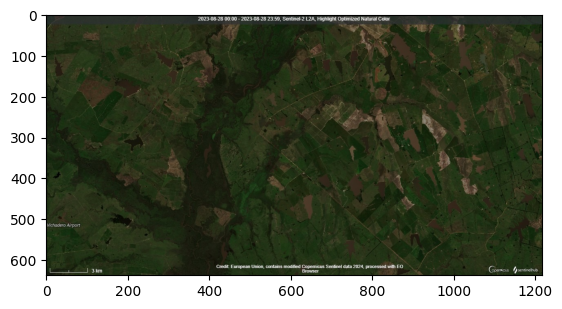

In [ ]:
plt.imshow(imagem_01)

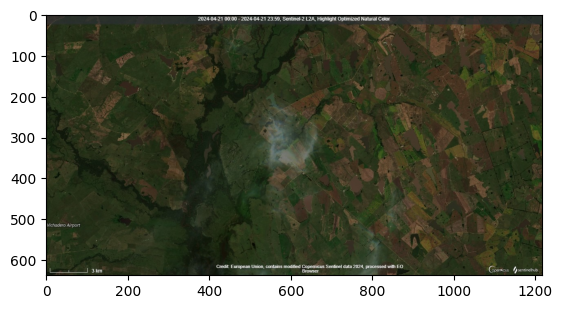

In [ ]:
plt.imshow(imagem_02)

**Ao analisar as duas imagens acima, do mesmo território e em meses distintos, é possível identificar diferenças na coloração da vegetação de algumas partes.**

Para melhor visualização dessas divergências entre os mapas, foi feita uma divisão entre o array de pixels das imagens

<ipython-input-12-7331117b4f56>:2: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((imagem_01 / imagem_02))
<ipython-input-12-7331117b4f56>:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow((imagem_01 / imagem_02))


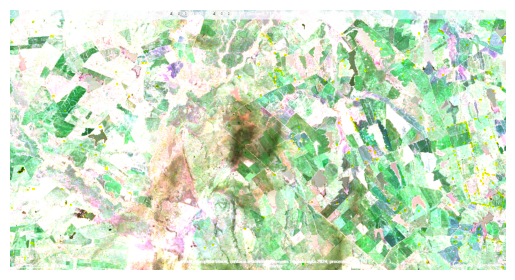

In [ ]:
plt.axis('off')
plt.imshow((imagem_01 / imagem_02))

## Identificação e contagem de classes:
Nossa base de dados é composta somente por imagens, sendo elas todas provenientes de regiões de cultivo. As imagens estão distribuídas em 2 classes, sendo a primeira chamada de Sem Talhões e a segunda classe chamada de Com Talhões. Segue um descritivo de cada classe:

Sem Talhões: São imagens sem as demarcações dos talhões, possuímos 20 imagens pertencentes a essa classe.

Com Talhões: São imagens com as demarcações dos talhões, possuímos 20 imagens pertencentes a essa classe.

## Visualização de exemplos:
Como explicitado acima possuímos 2 classes de imagens, segue um exemplo de cada uma das classes.

Classe Sem Talhão:

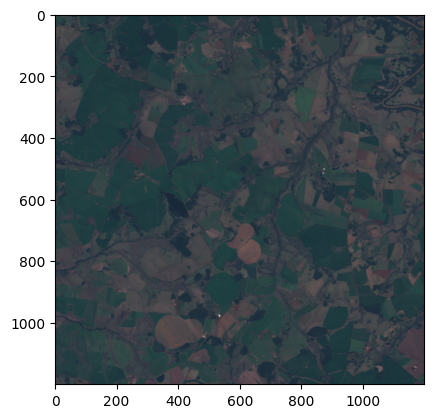

In [ ]:
imgSemTalhao = img.imread('/content/575_2019-8-14_S2L1C_21JXJ_TCI.png')

plt.imshow(imgSemTalhao)

Classe Com Talhão:

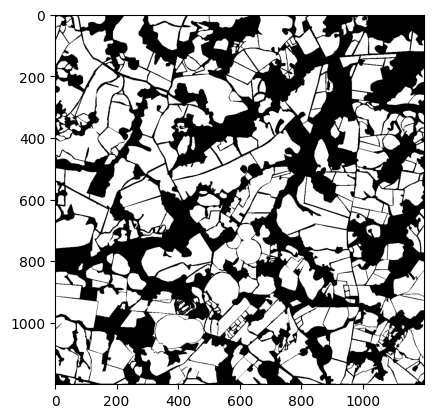

In [ ]:
imgComTalhao = img.imread('/content/575.png')

plt.imshow(imgComTalhao, cmap='gray')

## Análise de vieses:
Foi estabelecido em colaboração com nosso parceiro de projeto a importância de priorizar imagens da região Sul do país para o treinamento do modelo de detecção de talhões. Isso se justifica pela predominância de talhões mais irregulares nessa região sem seguir um padrão pré estabelecido. Em contraste, regiões como o Centro-Oeste tendem a apresentar talhões mais recentes e melhor padronizados. Portanto, concentrar-se na região Sul proporciona um conjunto de dados mais consistente e representativo das condições reais encontradas pelo nosso parceiro. Nossa decisão de privilegiar regiões com talhões mais irregulares e não padronizados baseia-se nas necessidades e desafios específicos apresentados pelo nosso parceiro. De acordo com suas experiências anteriores, a identificação de talhões na região Sul tem sido particularmente difícil devido à presença de padrões mais complexos e variados. Isso inclui bordas difusas, formatos irregulares e sobreposições de culturas, que representam um desafio significativo para os modelos de detecção. Portanto, ao treinar o modelo com talhões mais irregulares, visamos melhorar sua capacidade de generalização e adaptação a essas condições desafiadoras, garantindo resultados mais precisos e aplicáveis na prática. Nós acreditamos que ao usar regiões irregulares o modelo também conseguirá identificar regiões com talhões padronizados.

## Propriedades das imagens:
É de extrema importância para a eficiência do treinamento do modelo mantermos um padrão nas propriedades das imagens, como por exemplo o tamanho e a cor para que não atrapalhe o aprendizado do modelo, visto que ele irá buscar uma linha de raciocínio ao longo do dataset de treino e essas alterações exijam que o modelo tenha um raciocínio específico para cada imagem que ele é incapaz de ter. Ao longo do tópico vamos abordar algumas propriedades que podem ser consideradas relevantes para o treinamento

#### Tamanho da imagem

In [ ]:
imagem = img.imread('/content/575_2019-8-14_S2L1C_21JXJ_TCI.png')

In [ ]:
imagem.shape

(1200, 1200, 4)

Como pode ser visto no resultado printado pela célula de código anterior, estamos trabalhando com imagens de proporção 1200 por 1200 pixels. A última informação, exemplificada por 4 no exemplo dado, refere-se ao número de canais de cores, que ao serem combinados tornam a imagem colorida assim como estamos acostumados em ver imagens no geral.

Com o intuito de otimizar o aprendizado da rede, precisamos de um número de imagens superior à 20, mas não necessariamente isso quer dizer que precisamos criar novas imagens, podemos fazer apenas recortes e diminuir esse tamanho de 1200 para 200 pixels, por exemplo, desde que ao fazer a alteração uma vez, ela deve se replicar para que novamente o dataset inteiro mantenha todas as imagens com o mesmo tamanho

#### Cor

Como dito anteriormente, para que a imagem fique colorida, por tras de cada pixel há várias camadas, para este caso temos a combinação de 4 canais diferentes, sendo 3 de cor (vermelho, verde e azul) e 1 de opacidade

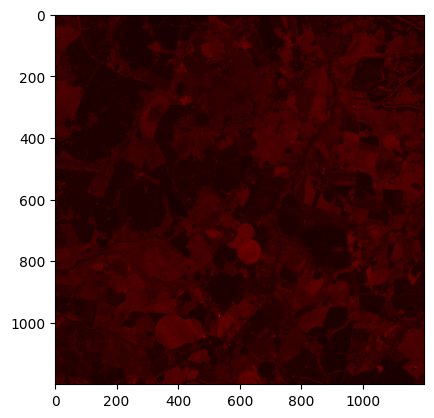

In [ ]:
imagem_vermelho = imagem.copy()
imagem_vermelho[:, :, 1] = 0
imagem_vermelho[:, :, 2] = 0

plt.imshow(imagem_vermelho)

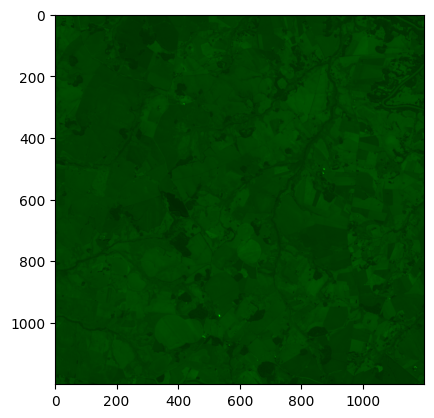

In [ ]:
imagem_verde = imagem.copy()
imagem_verde[:, :, 0] = 0
imagem_verde[:, :, 2] = 0

plt.imshow(imagem_verde)

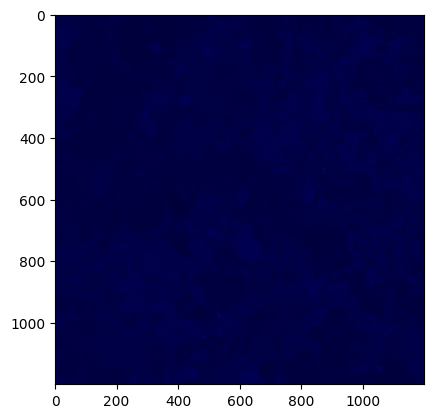

In [ ]:
imagem_azul = imagem.copy()
imagem_azul[:, :, 0] = 0
imagem_azul[:, :, 1] = 0

plt.imshow(imagem_azul)

Para uma melhor padronização dos dados, resolvemos então transformar a imagem toda para tons de cinza, dessa forma o padrão de cor seria igual para todas as imagens do dataset, facilitando o aprendizado da máquina

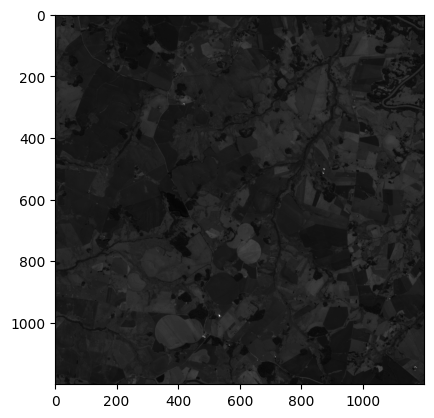

In [ ]:
imagem_cinza = 0.2989 * imagem[:, :, 0] + 0.5870 * imagem[:, :, 1] + 0.1140 * imagem[:, :, 2]

plt.imshow(imagem_cinza, cmap='gray')